# Data import & preprocessing 

In [9]:
# Import csv file from "HEI/Finalized_results" folder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

In [10]:
# import radium data
from pathlib import Path
root = Path.cwd().parent

DATA_DIR = root/'Dataset'
OUTPUT_DIR = root/'Results'


In [ ]:
# Import csv file
# Each csv file contains:
### df_final: all samples with analytes' concentrations and features for stats/spatial analysis
### df_full: all groundwater and spring samples with analytes' concentrations only (used for easier set up of stats comparison)
### df_unit: unit of analytes
### df_epa: EPA MCL/SMCL standards and thresholds related to potential health risks 
df_final = pd.read_csv(DATA_DIR/'2024_swpa_dataset.csv',header = 0)
df_full = pd.read_csv(DATA_DIR/'Full_Table_Data_for_stats.csv',header = 0)
df_unit = pd.read_csv(DATA_DIR/'Full_Table_Units.csv',header = 0)
df_epa = pd.read_csv(DATA_DIR/'EPA_Standard_with_health_risk.csv',header = 0)

In [12]:
df_final.shape

(97, 69)

In [13]:
df_final.columns

Index(['Site ID', 'Sample Group', 'Date', 'Time Sampled', 'Source', 'Temp',
       'DO', 'SC', 'Field pH', 'Lab pH', 'Alkalinity', 'Titration Date',
       'Gas Rover Reading', 'F', 'Cl', 'SO4', 'Br', 'NO3', 'Al', 'Ba', 'Ca',
       'Fe', 'K', 'Mg', 'Mn', 'Na', 'P', 'Si', 'Sr', 'Ti', 'Li', 'Be', 'Ni',
       'Cu', 'As', 'Sr.1', 'Cd', 'Tl', 'Pb', 'U', '87Sr/86Sr',
       '87Sr/86Sr Error', '87Sr/86Sr Ratio', 'Benzene', 'Toluene',
       'Ethylbenzene', 'm,p-Xylene', 'o-Xylene', 'Methane', 'Ethane',
       'Propane', 'δ13C1(‰)', 'δDC1(‰)', 'δ13C2(‰)', 'DIC (mg C/L)',
       'DIC (SD)', 'DIC (mol/L C)', '[H+]', '[OH-]', 'a0 [H2CO3]',
       'a1 [HCO3-]', 'a2 [CO32-]', 'Alk (eq/L)', 'Alk (mg CaCO3/L)',
       'NEAR_UOG_DIST', 'Impoundment_DIST', 'Recent_Spill_DIST', 'TPI300',
       'Near_Road_DIST'],
      dtype='object')

In [18]:
# Check out number of samples in each sample group
df_final['Sample Group'].value_counts()

Sample Group
Extra    27
S        17
HS       17
I        14
HS/I     10
C         8
HS/S      4
Name: count, dtype: int64

In [23]:
### Remove stream samples
df_final = df_final.loc[~df_final['Source'].str.contains('stream')]

### Remove the AMD and rain samples
### Drop rows that has Site ID equals to Sample_022, Sample_029, Sample_091
df_final = df_final.loc[~df_final['Site ID'].isin(['Sample_022', 'Sample_029', 'Sample_091']),:]
df_full = df_full.loc[~df_full['Site ID'].isin(['Sample_022', 'Sample_029', 'Sample_091']),:]
df_final.shape

(90, 69)

In [24]:
df_unit =df_unit.set_index('Unnamed: 0')
df_unit.index.name = None
df_unit

,Unit
Site ID,-
Sample Group,-
Date,-
Time Sampled,-
Source,-
...,...
228Ra/226Ra,pCi/L
Ra 226+228,pCi/L
Ra226,pCi/L
Ra228,pCi/L


In [26]:
df_epa

,list,MCL/SMCL limit
0,DO,-
1,SC,-
2,Field pH,6.5-8.5
3,Lab pH,6.5-8.5
4,Alkalinity,-
5,Gas Rover Reading,-
6,F,2
7,Cl,250
8,SO4,250
9,Br,2


# <span style = 'color: red'> *Define functions that generate stats summary* </span>

- **epa_table(df):**

  - 'list' of analytes
  - 'EPA Standard' regulated thresholds
  - '% exceeding EPA Standard' among all samples


- **stats_summary(df,df_unit,epa):**

  - unit & number of valid measurement
  - minimum, maximum, mean, median, and 5% and 95% percentiles
  - epa table

In [27]:
# Define a function that generate epa tables
def epa_table(df):
  epa = df_epa
  # Create a new column that stores the percentage values in df
  epa['Percentage'] = "-"
  for col in df.columns:
    # EPA secondary standard for pH : 6.5 - 8.5
    if 'pH' in col:
      sum_pH = ((df[col] < 6.5) | (df[col] > 8.5)).sum()
      perc = f"{sum_pH / df[col].count() * 100:.1f}% ({sum_pH})"
      epa.loc[epa['list']== col, 'Percentage'] = perc

    # EPA secondary standard for Al : 0.05 - 0.2 mg/L, here would be using 0.2 mg/L as the threshold
    elif col == 'Al' :
      sum_al = (df[col] > 0.2).sum()
      perc = f"{sum_al / df[col].count() * 100:.1f}% ({sum_al})"
      epa.loc[epa['list']== col, 'Percentage'] = perc

    # Other EPA standards according to the table
    elif epa.loc[epa['list']== col, 'MCL/SMCL limit'].astype(str).ne('-').any():
      epa_standard = epa.loc[epa['list'] == col, 'MCL/SMCL limit'].astype(float).iloc[0]
      sum = (df[col] > epa_standard).sum()
      perc = f"{sum / df[col].count() * 100:.1f}% ({sum})"
      epa.loc[epa['list']== col, 'Percentage'] = perc
  epa = epa.rename(columns={'Percentage': '% Exceeding MCL/SMCL'})
  return epa

In [28]:
# Define a function that generate stats summary
def stats_summary(df,df_unit,epa):
  num_values = df.count()
  min_values = df.min()
  max_values = df.max()
  mean_values = df.mean()
  median_values = df.median(axis=0)
  upper_quartile = df.quantile(0.75, axis=0)
  lower_quartile = df.quantile(0.25, axis=0)
  upper_95_percentile = df.quantile(0.95, axis=0)
  lower_5_percentile = df.quantile(0.05, axis=0)


  df_summary = pd.DataFrame({
    'n' : num_values,
    'Min': min_values,
    'Max': max_values,
    'Mean': mean_values,
    'Median': median_values,
    '5th Percentile': lower_5_percentile,
    '25th Percentile': lower_quartile,
    '75th Percentile': upper_quartile,
    '95th Percentile': upper_95_percentile
  })

  # Remove row with index 'Ti'
  df_summary = df_summary.drop(index='Ti')

  # Keep 3 digits after decimal for all values other than Sr ratio. This may exclude some values that are too small
  df_summary.loc[df_summary.index != '87Sr/86Sr'] = df_summary.loc[df_summary.index != '87Sr/86Sr'].round(3)
  df_summary.loc[df_summary.index == '87Sr/86Sr'] = df_summary.loc[df_summary.index == '87Sr/86Sr'].round(4)

  # Append the units from df_unit and EPA standards & percentages from df_epa
  df_summary_1 = pd.merge(df_summary, df_unit, left_index=True, right_index=True, how='left')
  df_summary_2 = pd.merge(df_summary_1, epa, left_on=df_summary_1.index, right_on='list', how='left')
  df_summary_2 = df_summary_2.set_index(df_summary_1.index)
  df_summary_2 = df_summary_2.drop(columns=['list'])

  # Fill na with "-"
  df_summary_2 = df_summary_2.fillna('-')

  # Move the units to the first column
  units = df_summary_2.pop('Unit')
  df_summary_2.insert(0, 'Unit', units)


  # Make the index as the first column
  df_summary_2 = df_summary_2.reset_index()
  df_summary_2 = df_summary_2.rename(columns={'index': 'Analyte'})

  # Delete the line where analyte is 'Lab pH'
  df_summary_2 = df_summary_2.loc[df_summary_2['Analyte'] != 'Lab pH', :]

  # Change the name of analyte 'Field pH' to 'pH', and 'Gas Rover Reading' to 'Air [CH4]'
  df_summary_2['Analyte'] = df_summary_2['Analyte'].replace('Field pH', 'pH')
  df_summary_2['Analyte'] = df_summary_2['Analyte'].replace('Gas Rover Reading', 'Air [CH4]')
  df_summary_2['Analyte'] = df_summary_2['Analyte'].replace('NO3', 'NO3-NO3')


  return df_summary_2

# **Full table stats summary: All groundwater and spring samples (Table S2)**

In [29]:
df_full.shape

(90, 48)

In [31]:
df_full.columns

Index(['Unnamed: 0', 'Site ID', 'DO', 'SC', 'Field pH', 'Lab pH', 'Alkalinity',
       'Gas Rover Reading', 'F', 'Cl', 'SO4', 'Br', 'NO3', 'Al', 'Ba', 'Ca',
       'Fe', 'K', 'Mg', 'Mn', 'Na', 'P', 'Si', 'Sr', 'Ti', 'Li', 'Be', 'Ni',
       'Cu', 'As', 'Cd', 'Tl', 'Pb', 'U', '87Sr/86Sr', 'Benzene', 'Toluene',
       'Ethylbenzene', 'm,p-Xylene', 'o-Xylene', 'Xylene(total)', 'Methane',
       'Ethane', 'Propane', 'δ13C1(‰)', 'δDC1(‰)', 'δ13C2(‰)', 'Radon'],
      dtype='object')

In [34]:
### All samples
df_well_spring = df_full.drop(columns=['Site ID'])
df_well_spring.columns

Index(['DO', 'SC', 'Field pH', 'Lab pH', 'Alkalinity', 'Gas Rover Reading',
       'F', 'Cl', 'SO4', 'Br', 'NO3', 'Al', 'Ba', 'Ca', 'Fe', 'K', 'Mg', 'Mn',
       'Na', 'P', 'Si', 'Sr', 'Ti', 'Li', 'Be', 'Ni', 'Cu', 'As', 'Cd', 'Tl',
       'Pb', 'U', '87Sr/86Sr', 'Benzene', 'Toluene', 'Ethylbenzene',
       'm,p-Xylene', 'o-Xylene', 'Xylene(total)', 'Methane', 'Ethane',
       'Propane', 'δ13C1(‰)', 'δDC1(‰)', 'δ13C2(‰)'],
      dtype='object')

In [35]:
epa_well_spring = epa_table(df_well_spring)
df_well_spring_summary = stats_summary(df_well_spring,df_unit,epa_well_spring)
df_well_spring_summary.to_csv(os.path.join(OUTPUT_DIR,'Tables','Table S2.csv'),index=False)

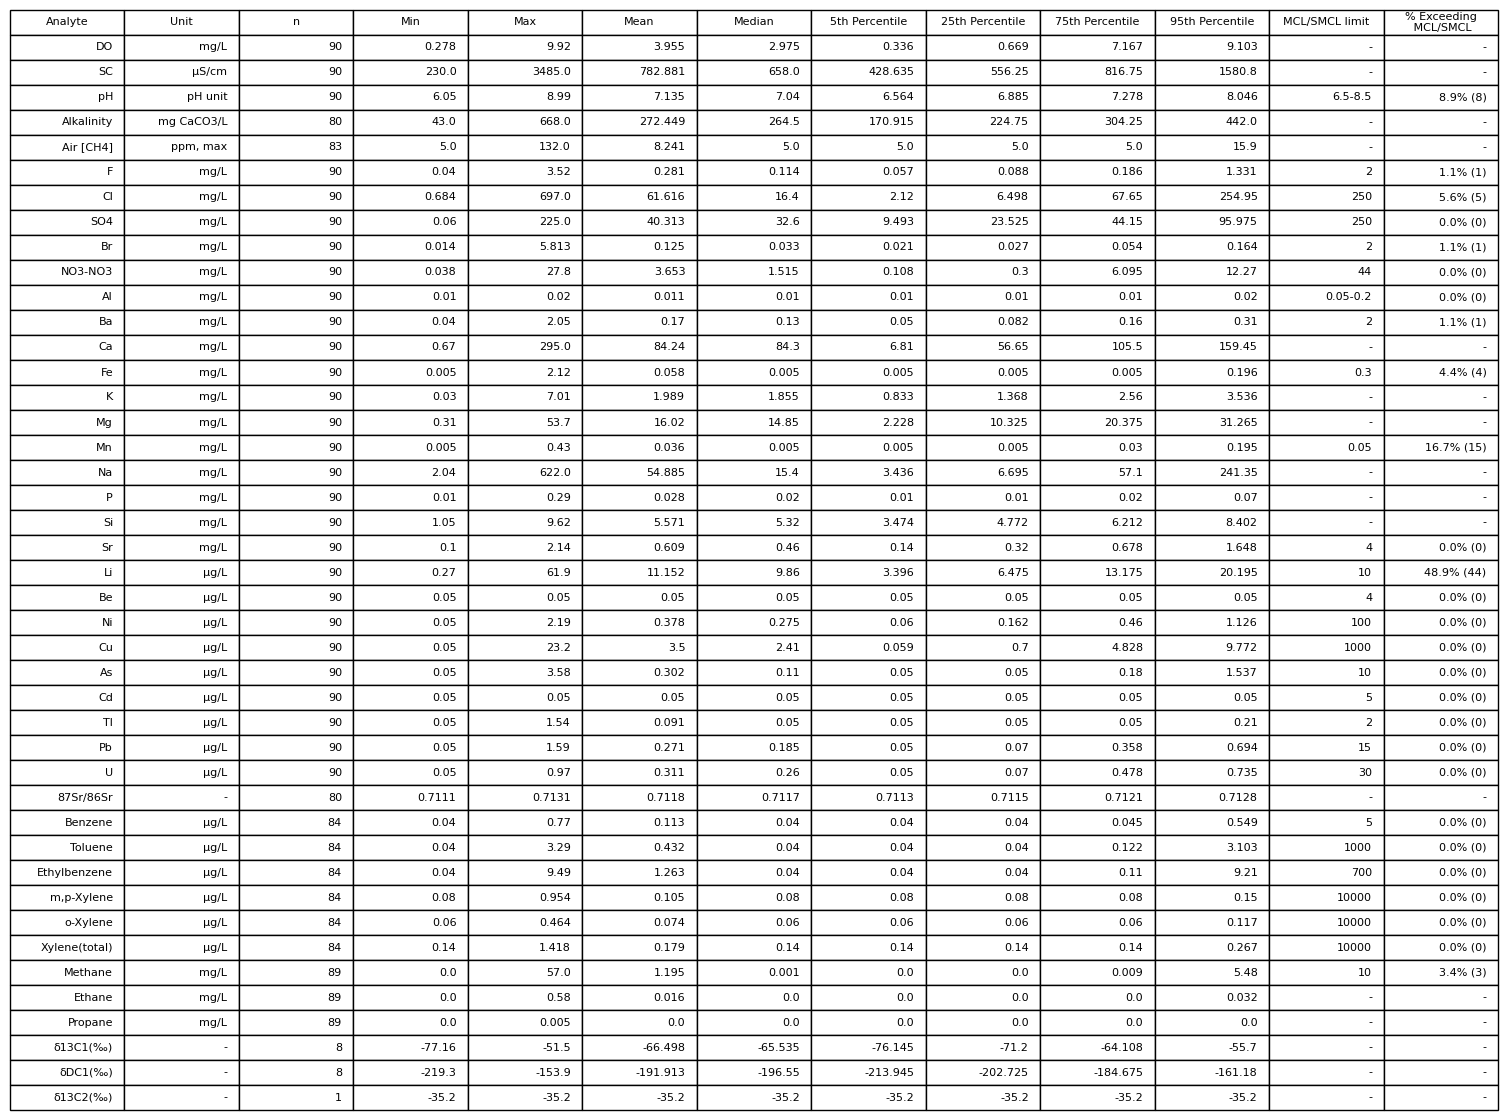

In [36]:
col_label = df_well_spring_summary.columns.tolist()
col_label[-1] = '% Exceeding\n MCL/SMCL'

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size as needed
ax.axis('off')  # Remove axes

# Create the table
table = ax.table(cellText=df_well_spring_summary.values,
                colLabels=col_label,
                loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.6, 1.5)  # Adjust scaling for better spacing

# Export the figure
# plt.savefig(OUTPUT_DIR/'Figures/Well_spring_summary_table_figure.png', bbox_inches='tight')
plt.show()

# **Table S3: Hotspot samples**

In [51]:
df_full.shape

(90, 46)

In [52]:
df_final.shape

(90, 69)

In [48]:
# Table includes df_full and source/sample group info from df_final
df_extract = pd.merge(df_full,df_final[['Site ID','Source','Sample Group']],on='Site ID')
df_extract.columns

Index(['Site ID', 'DO', 'SC', 'Field pH', 'Lab pH', 'Alkalinity',
       'Gas Rover Reading', 'F', 'Cl', 'SO4', 'Br', 'NO3', 'Al', 'Ba', 'Ca',
       'Fe', 'K', 'Mg', 'Mn', 'Na', 'P', 'Si', 'Sr', 'Ti', 'Li', 'Be', 'Ni',
       'Cu', 'As', 'Cd', 'Tl', 'Pb', 'U', '87Sr/86Sr', 'Benzene', 'Toluene',
       'Ethylbenzene', 'm,p-Xylene', 'o-Xylene', 'Xylene(total)', 'Methane',
       'Ethane', 'Propane', 'δ13C1(‰)', 'δDC1(‰)', 'δ13C2(‰)', 'Source',
       'Sample Group'],
      dtype='object')

In [50]:
df_extract.shape

(90, 48)

In [53]:
# Generate table 1 & export it before doing stats analysis
df_hs = df_extract[df_extract['Sample Group'].str.contains('HS')]

# # Create groups without spring samples
df_hs_well = df_hs[df_hs['Source'].str.contains('well')]

df_hs = df_hs.drop(columns=['Sample Group','Source', 'Site ID'])
df_hs_well = df_hs_well.drop(columns=['Sample Group','Source', 'Site ID'])

# Generate epa table
epa_hs = epa_table(df_hs)
# Generate stats summary and save it to a csv
df_hs_summary = stats_summary(df_hs,df_unit,epa_hs)
df_hs_summary.to_csv(os.path.join(OUTPUT_DIR,'Tables','Table S3.csv'),index=False)

# **Table S4: Impoundment samples**

In [78]:
df_i = df_extract[df_extract['Sample Group'].str.contains('I')]

# Get samples with only well samples
df_i_well = df_i[df_i['Source'].str.contains('well')]
df_i = df_i.drop(columns=['Sample Group','Source','Site ID'])
df_i_well = df_i_well .drop(columns=['Sample Group','Source','Site ID'])
# Generate epa table
epa_i = epa_table(df_i)
# Generate stats summary and save it to a csv
df_i_summary = stats_summary(df_i,df_unit,epa_i)
df_i_summary.to_csv(os.path.join(OUTPUT_DIR,'Tables','Tables S4.csv'))

# **Table S5: Spill samples**

In [55]:
df_s = df_extract[(df_extract['Sample Group']=='S') | (df_extract['Sample Group'].str.contains('HS/S'))]

# Get a table with only well samples
df_s_well = df_s[df_s['Source'].str.contains('well')]
df_s = df_s.drop(columns=['Source','Sample Group','Site ID'])
df_s_well = df_s_well .drop(columns=['Source','Sample Group','Site ID'])
# Generate epa table
epa_s = epa_table(df_s)
# Generate stats summary and save it to a csv
df_s_summary = stats_summary(df_s,df_unit,epa_s)
df_s_summary.to_csv(os.path.join(OUTPUT_DIR,'Tables','Tables S5.csv'))

# **Table S6: Control Samples**

In [57]:
df_c = df_extract[df_extract['Sample Group'].str.contains('C')]
df_c_well = df_c[df_c['Source'].str.contains('well')]

df_c = df_c.drop(columns=['Sample Group','Source', 'Site ID'])
df_c_well = df_c_well.drop(columns=['Sample Group','Source', 'Site ID'])
# Generate epa table
epa_c = epa_table(df_c)
# Generate stats summary and save it to a csv
df_c_summary = stats_summary(df_c,df_unit,epa_c)
df_c_summary.to_csv(os.path.join(OUTPUT_DIR,'Tables','Tables S6.csv'))

# **Regression Analysis**
OLS + Spearman + Kendall's Tau (non-parametric correlation) + ATS slope





In [58]:
# Create a function that calcuate the kendall's Tau, p-value nad ATS slope between two dataset

from scipy.stats import kendalltau
from scipy.stats import theilslopes
from scipy.stats import spearmanr
from scipy.stats import linregress


def Correlation_test(df, feature): # df is the analytes' columns and feature is geospatial features (e.g., distance to closest sites, road density, etc.)

  # Store the results
  result = {}
  significance_threshold = 0.05

  for column in df.columns:

    # Drop na from the columns
    temp_df = pd.concat([df[column], feature], axis=1).dropna()
    col1 = temp_df[column]
    col2 = temp_df[feature.name]

    # Calculate linear regression
    if 'DIST' in feature.name:

      # log transformation to the concentration data
      # col1 = np.log(col1+1)

      # turn unit of feature from m to km

      col2 = col2/1000

      # Calculate linear regression
      ols_slope, ols_intercept, ols_r_value, ols_p_value, ols_std_err = linregress(col2, col1)
    else:
      ols_slope = np.nan
      ols_p_value = np.nan
    # Calculate spearman correlation
    spearman_corr, spearman_p = spearmanr(col1, col2)
    # Calculate Kendall's Tau
    tau, p_value = kendalltau(col1, col2)
    # Calculat ATS slopes
    slope, intercept, lo_slope, hi_slope = theilslopes(col2, col1, 0.95)
    # flag the significant correlations
    result[column] = {
          'OLS_slope': f'{ols_slope:.3f}'+ '\n' +('*' if ols_p_value <significance_threshold else '') + f'({ols_p_value:.3f}, R²={ols_r_value:.3f})',
        'Spearman': f'{spearman_corr:.3f}'+ ('*' if spearman_p <significance_threshold else '') + f'({spearman_p:.3f})',
        'Kendall\'s Tau': f'{tau:.3f}'+ ('*' if p_value <significance_threshold else '') + f'({p_value:.3f})',
        'ATS slope': f'{slope:.3f}'}

  result = pd.DataFrame(result)
  print(result)
  return result



In [59]:
df_corr = pd.merge(df_full, df_final[['Site ID','Source',
'NEAR_UOG_DIST', 'Impoundment_DIST', 'Recent_Spill_DIST']], on='Site ID')

df_corr_well = df_corr[df_corr['Source'].str.contains('well')]

df_corr.columns

Index(['Site ID', 'DO', 'SC', 'Field pH', 'Lab pH', 'Alkalinity',
       'Gas Rover Reading', 'F', 'Cl', 'SO4', 'Br', 'NO3', 'Al', 'Ba', 'Ca',
       'Fe', 'K', 'Mg', 'Mn', 'Na', 'P', 'Si', 'Sr', 'Ti', 'Li', 'Be', 'Ni',
       'Cu', 'As', 'Cd', 'Tl', 'Pb', 'U', '87Sr/86Sr', 'Benzene', 'Toluene',
       'Ethylbenzene', 'm,p-Xylene', 'o-Xylene', 'Xylene(total)', 'Methane',
       'Ethane', 'Propane', 'δ13C1(‰)', 'δDC1(‰)', 'δ13C2(‰)', 'Source',
       'NEAR_UOG_DIST', 'Impoundment_DIST', 'Recent_Spill_DIST'],
      dtype='object')

In [60]:
# Define the analytes of interests
df_analyte = df_corr[['SC','Na','Cl','Ba','SO4','Sr','Br', 'Fe','Methane']]
df_analyte_well = df_corr_well[['SC','Na','Cl','Ba','SO4','Sr','Br', 'Fe','Methane']]


## **Regression for well + spring samples**
Table 3

In [63]:
# Hotspot
regress_hs = Correlation_test(df_analyte, df_corr['NEAR_UOG_DIST'])

### Save the results as a separate table (optional)
# regress_hs.to_csv(os.path.join(OUTPUT_DIR,'Tables','Regression_hotspot(Table 3 HS).csv'), header=True, index=True)

                                     SC                         Na  \
OLS_slope      2.930\n(0.697, R²=0.042)  3.055\n*(0.047, R²=0.210)   
Spearman                  -0.099(0.355)               0.026(0.807)   
Kendall's Tau             -0.071(0.324)               0.022(0.756)   
ATS slope                        -0.001                      0.002   

                                     Cl                        Ba  \
OLS_slope      0.119\n(0.949, R²=0.007)  0.003\n(0.415, R²=0.087)   
Spearman                  -0.051(0.631)             -0.041(0.699)   
Kendall's Tau             -0.038(0.594)             -0.029(0.693)   
ATS slope                        -0.002                    -1.633   

                                      SO4                          Sr  \
OLS_slope      -0.588\n(0.264, R²=-0.119)  -0.005\n(0.500, R²=-0.072)   
Spearman                    -0.206(0.051)               -0.109(0.306)   
Kendall's Tau               -0.133(0.063)               -0.069(0.339)   
ATS slope  

In [64]:
# Impoundment
regress_i = Correlation_test(df_analyte, df_corr['Impoundment_DIST'])

### Save the results as a separate table (optional)
# regress_i.to_csv(os.path.join(OUTPUT_DIR,'Tables','Regression_impoundment(Table 3 I).csv'), header=True, index=True)

                                      SC                         Na  \
OLS_slope      11.504\n(0.152, R²=0.152)  4.617\n*(0.005, R²=0.296)   
Spearman                   -0.063(0.558)               0.050(0.637)   
Kendall's Tau              -0.034(0.633)               0.033(0.648)   
ATS slope                         -0.001                      0.004   

                                     Cl                        Ba  \
OLS_slope      1.860\n(0.353, R²=0.099)  0.007\n(0.078, R²=0.186)   
Spearman                  -0.085(0.427)             -0.129(0.224)   
Kendall's Tau             -0.050(0.488)             -0.086(0.242)   
ATS slope                        -0.004                    -5.060   

                                    SO4                          Sr  \
OLS_slope      0.077\n(0.892, R²=0.015)  -0.005\n(0.493, R²=-0.073)   
Spearman                   0.028(0.794)              -0.225*(0.033)   
Kendall's Tau              0.030(0.678)              -0.151*(0.036)   
ATS slope     

In [65]:
# Spill
regress_s = Correlation_test(df_analyte, df_corr['Recent_Spill_DIST'])

### Save the results as a separate table (optional)
# regress_s.to_csv(os.path.join(OUTPUT_DIR,'Tables','Regression_spill(Table 3 S).csv'), header=True, index=True)

                                        SC                           Na  \
OLS_slope      -15.816\n(0.256, R²=-0.121)  -5.954\n*(0.037, R²=-0.220)   
Spearman                      0.000(0.999)               -0.307*(0.003)   
Kendall's Tau                -0.002(0.975)               -0.209*(0.004)   
ATS slope                           -0.000                       -0.018   

                                       Cl                           Ba  \
OLS_slope      -4.165\n(0.229, R²=-0.128)  -0.014\n*(0.050, R²=-0.207)   
Spearman                    -0.119(0.263)                -0.084(0.432)   
Kendall's Tau               -0.084(0.240)                -0.054(0.461)   
ATS slope                          -0.006                       -2.696   

                                    SO4                          Sr  \
OLS_slope      1.072\n(0.273, R²=0.117)  -0.011\n(0.400, R²=-0.090)   
Spearman                  0.208*(0.049)               -0.048(0.656)   
Kendall's Tau             0.145*(0.043) 

In [ ]:
# Save all the results together 
regress_hs['Coefficient'] = regress_hs.index
regress_i['Coefficient'] = regress_i.index
regress_s['Coefficient'] = regress_s.index

regress_hs.index = ['HS'] * len(regress_hs)
regress_i.index = ['I'] * len(regress_i)
regress_s.index = ['S'] * len(regress_s)



,SC,Na,Cl,Ba,SO4,Sr,Br,Fe,Methane,Coefficient
HS,"2.930\n(0.697, R²=0.042)","3.055\n*(0.047, R²=0.210)","0.119\n(0.949, R²=0.007)","0.003\n(0.415, R²=0.087)","-0.588\n(0.264, R²=-0.119)","-0.005\n(0.500, R²=-0.072)","0.012\n(0.201, R²=0.136)","0.002\n(0.654, R²=0.048)","0.206\n*(0.038, R²=0.221)",OLS_slope
HS,-0.099(0.355),0.026(0.807),-0.051(0.631),-0.041(0.699),-0.206(0.051),-0.109(0.306),0.086(0.422),0.139(0.192),0.310*(0.003),Spearman
HS,-0.071(0.324),0.022(0.756),-0.038(0.594),-0.029(0.693),-0.133(0.063),-0.069(0.339),0.058(0.419),0.104(0.211),0.214*(0.004),Kendall's Tau
HS,-0.001,0.002,-0.002,-1.633,-0.028,-0.849,2.238,5.069,1.985,ATS slope


In [72]:
regression_results = pd.concat([regress_hs, regress_i, regress_s])

# Bring the coefficient column to the front
cols = ['Coefficient'] + [col for col in regression_results.columns if col != 'Coefficient']
regression_results = regression_results[cols]
regression_results['Treatment Group'] = regression_results.index
regression_results = regression_results.reset_index(drop=True)
regression_results.to_csv(os.path.join(OUTPUT_DIR,'Tables','Table 3 Regression Analysis.csv'), index=False)

# **One-sided test with Benjamin - Hochberg (BH) procedure**
Table S7 - S8

## **Define Functions**

In [74]:
### Analyte for comparison
analyte_list = ['DO', 'SC', 'F', 'Cl', 'SO4', 'Br', 'NO3', 'Al', 'Ba', 'Ca', 'Fe', 'K',
    'Mg', 'Mn', 'Na', 'P', 'Si', 'Sr', 'Li', 'Be', 'Ni', 'Cu', 'As', 'Cd',
    'Tl', 'Pb', 'U', 'Benzene', 'Toluene', 'Ethylbenzene', 'm,p-Xylene',
    'o-Xylene', 'Xylene(total)', 'Methane', 'Ethane', 'Propane']

In [ ]:
# Define one-sided test with BH in a function
from scipy.stats import mannwhitneyu
from scipy.stats import brunnermunzel
from statsmodels.stats.multitest import multipletests

def one_sided_bh_wmw(df_1, df_2, df_1_name, df_2_name):

    # Store the p-value for bh correction
    p_values_greater = []
    p_values_less = []
    median_diff = []

    significance_threshold = 0.05

    for feature in df_1.columns:
        # Create copies of the columns for comparison
        col1 = df_1[feature].dropna()
        col2 = df_2[feature].dropna()

        # Test if Group A has higher values
        stat_greater, p_value_greater = mannwhitneyu(col1, col2, alternative='greater')
        p_values_greater.append(p_value_greater)

        # Test if Group A has lower values
        stat_less, p_value_less = mannwhitneyu(col1, col2, alternative='less')
        p_values_less.append(p_value_less)

        # Calculate the median difference
        median_diff.append(col1.median() - col2.median())



    ### Applying bh ###
    p_values_greater = np.array(p_values_greater)
    p_values_less = np.array(p_values_less)
    median_diff = np.array(median_diff)

    # Combine p-values
    all_pvalues = np.concatenate([p_values_greater, p_values_less])

    # Apply BH correction to all 40 tests
    fdr_level = 0.1
    rejected, p_adjusted, _, _ = multipletests(all_pvalues, alpha=fdr_level, method='fdr_bh')

    results_df = pd.DataFrame({
        'analyte': np.tile(df_1.columns, 2),
        'test': [f'{df_1_name} > {df_2_name}']*df_1.shape[1] + [f'{df_1_name} < {df_2_name}']*df_1.shape[1],
        'original_pvalue': all_pvalues,
        'adjusted_pvalue': p_adjusted,
        'significant': rejected
    })

    # Display the results
    significant_results = results_df[results_df['significant']]
    one_sided_results = results_df[results_df['original_pvalue']<0.05]

    # Group analytes by test and display as two columns
    df_grouped = one_sided_results.groupby('test')['analyte'].apply(list).reset_index()
    df_grouped.columns = ['Significant Difference', 'WMW']
    df_grouped = df_grouped.sort_values('Significant Difference', ascending=False).reset_index(drop=True)


    print("One-Sided Test Results for Significant Features:")
    print(significant_results)
    print("\n")
    print("Without fdr:",'\n')
    print(one_sided_results)
    print("\n")
    print("Grouped by test (without fdr):",'\n')
    print(df_grouped)

    return significant_results, df_grouped

In [ ]:
def one_sided_bh_bm(df_1, df_2,df_1_name,df_2_name):

    # Store the p-value for bh correction
    p_values_greater = []
    p_values_less = []
    median_diff = []

    significance_threshold = 0.05

    for feature in df_1.columns:
        # Create copies of the columns for comparison
        col1 = df_1[feature].dropna()
        col2 = df_2[feature].dropna()

        # Test if Group A has higher values
        stat_greater, p_value_greater = brunnermunzel(col1, col2, alternative='greater')
        p_values_greater.append(p_value_greater)

        # Test if Group A has lower values
        stat_less, p_value_less = brunnermunzel(col1, col2, alternative='less')
        p_values_less.append(p_value_less)

        # Calculate the median difference
        median_diff.append(col1.median() - col2.median())



    ### Applying bh ###
    p_values_greater = np.array(p_values_greater)
    p_values_less = np.array(p_values_less)
    median_diff = np.array(median_diff)

    # Combine p-values
    all_pvalues = np.concatenate([p_values_greater, p_values_less])
    all_pvalues[np.isnan(all_pvalues)] = 1

    # Apply BH correction to all 40 tests
    fdr_level = 0.1
    rejected, p_adjusted, _, _ = multipletests(all_pvalues, alpha=fdr_level, method='fdr_bh')

    results_df = pd.DataFrame({
        'analyte': np.tile(df_1.columns, 2),
        'test': [f'{df_1_name} > {df_2_name}']*df_1.shape[1] + [f'{df_1_name} < {df_2_name}']*df_1.shape[1],
        'original_pvalue': all_pvalues,
        'adjusted_pvalue': p_adjusted,
        'significant': rejected
    })

    # Display the results
    significant_results = results_df[results_df['significant']]
    one_sided_results = results_df[results_df['original_pvalue']<0.05]

    # Group analytes by test and display as two columns
    df_grouped = one_sided_results.groupby('test')['analyte'].apply(list).reset_index()
    df_grouped.columns = ['Significant Difference', 'BM']
    df_grouped = df_grouped.sort_values('Significant Difference', ascending=False).reset_index(drop=True)
    
    print("One-Sided Test Results for Significant Features:")
    print(significant_results)
    print("\n")
    print("Without fdr:",'\n')
    print(one_sided_results)
    print("\n")
    print("Grouped by test (without fdr):",'\n')
    print(df_grouped)

    return significant_results, df_grouped

In [91]:
### Before reperforming the test, we setup the dataframes for comparison
df_HS = df_hs.loc[:,analyte_list]
df_I = df_i.loc[:,analyte_list]
df_S = df_s.loc[:,analyte_list]
df_C = df_c.loc[:,analyte_list]

## **One-sided tests: Well & Spring**
Table S7

In [98]:
# df_HS vs df_c
sig, hs_c_wmw = one_sided_bh_wmw(df_HS, df_c,'HS','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

         analyte    test  original_pvalue  adjusted_pvalue  significant
6            NO3  HS > C         0.020705         0.448206        False
11             K  HS > C         0.012023         0.448206        False
26             U  HS > C         0.043942         0.538586        False
51             P  HS < C         0.024900         0.448206        False
65  Ethylbenzene  HS < C         0.020173         0.448206        False


Grouped by test: 

  Significant Difference                WMW
0                 HS > C        [NO3, K, U]
1                 HS < C  [P, Ethylbenzene]


In [99]:
sig, hs_c_bm = one_sided_bh_bm(df_HS, df_C,'HS','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

   analyte    test  original_pvalue  adjusted_pvalue  significant
3       Cl  HS > C         0.047189         0.580555        False
6      NO3  HS > C         0.004696         0.183109        False
11       K  HS > C         0.005086         0.183109        False
26       U  HS > C         0.032108         0.577948        False
51       P  HS < C         0.025539         0.577948        False


Grouped by test: 

  Significant Difference               BM
0                 HS > C  [Cl, NO3, K, U]
1                 HS < C              [P]


C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8819: RuntimeWarning: invalid value encountered in scalar divide
  wbfn /= (nx + ny) * np.sqrt(nx * Sx + ny * Sy)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8825: RuntimeWarning: invalid value encountered in scalar divide
  df = df_numer / df_denom
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: p-value cannot be estimated with `distribution='t' because degrees of freedom parameter is undefined (0/0). Try using `distribution='normal'
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8

In [100]:
# df_I vs df_C
sig, i_c_wmw = one_sided_bh_wmw(df_I, df_C,'I','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

   analyte   test  original_pvalue  adjusted_pvalue  significant
3       Cl  I > C         0.035182          0.84438        False
25      Pb  I > C         0.018022          0.64878        False
51       P  I < C         0.015993          0.64878        False


Grouped by test: 

  Significant Difference       WMW
0                  I > C  [Cl, Pb]
1                  I < C       [P]


In [101]:
sig, i_c_bm = one_sided_bh_bm(df_I, df_C,'I','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

    analyte   test  original_pvalue  adjusted_pvalue  significant
25       Pb  I > C         0.019840         0.476149        False
27  Benzene  I > C         0.018612         0.476149        False
51        P  I < C         0.014424         0.476149        False


Grouped by test: 

  Significant Difference             BM
0                  I > C  [Pb, Benzene]
1                  I < C            [P]


C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8819: RuntimeWarning: invalid value encountered in scalar divide
  wbfn /= (nx + ny) * np.sqrt(nx * Sx + ny * Sy)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8825: RuntimeWarning: invalid value encountered in scalar divide
  df = df_numer / df_denom
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: p-value cannot be estimated with `distribution='t' because degrees of freedom parameter is undefined (0/0). Try using `distribution='normal'
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8

In [102]:
# df_S vs df_pure_c
sig, s_c_wmw = one_sided_bh_wmw(df_S, df_C,'S','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

   analyte   test  original_pvalue  adjusted_pvalue  significant
11       K  S > C         0.029687              1.0        False
21      Cu  S > C         0.023859              1.0        False


Grouped by test: 

  Significant Difference      WMW
0                  S > C  [K, Cu]


In [103]:
sig, s_c_bm = one_sided_bh_bm(df_S, df_C,'S','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

   analyte   test  original_pvalue  adjusted_pvalue  significant
11       K  S > C         0.018059         0.650128        False
21      Cu  S > C         0.013981         0.650128        False


Grouped by test: 

  Significant Difference       BM
0                  S > C  [K, Cu]


C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8819: RuntimeWarning: invalid value encountered in scalar divide
  wbfn /= (nx + ny) * np.sqrt(nx * Sx + ny * Sy)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8825: RuntimeWarning: invalid value encountered in scalar divide
  df = df_numer / df_denom
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: p-value cannot be estimated with `distribution='t' because degrees of freedom parameter is undefined (0/0). Try using `distribution='normal'
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8

In [ ]:
# Group all the results together
hs_c = pd.merge(hs_c_wmw, hs_c_bm, on=['Significant Difference'], how='outer').sort_values('Significant Difference', ascending=False)
i_c = pd.merge(i_c_wmw, i_c_bm, on=['Significant Difference'], how='outer').sort_values('Significant Difference', ascending=False)
s_c = pd.merge(s_c_wmw, s_c_bm, on=['Significant Difference'], how='outer').sort_values('Significant Difference', ascending=False)
# Save the results
Combine_all = pd.concat([hs_c, i_c, s_c], keys=['HS vs C', 'I vs C', 'S vs C']).droplevel(1)
Combine_all.to_csv(os.path.join(OUTPUT_DIR,'Tables','Table S7 One-sided Test.csv'), index=True)

,Significant Difference,WMW,BM
HS vs C,HS > C,"[NO3, K, U]","[Cl, NO3, K, U]"
HS vs C,HS < C,"[P, Ethylbenzene]",[P]
I vs C,I > C,"[Cl, Pb]","[Pb, Benzene]"
I vs C,I < C,[P],[P]
S vs C,S > C,"[K, Cu]","[K, Cu]"


## **One-sided tests: Well only**
Table S8

In [118]:
df_HS_well = df_hs_well.loc[:, analyte_list]
df_I_well = df_i_well.loc[:, analyte_list]
df_S_well = df_s_well.loc[:, analyte_list]
df_C_well = df_c_well.loc[:, analyte_list]

In [110]:
# df_HS_well vs df_C_well
sig, hs_c_well_wmw = one_sided_bh_wmw(df_HS_well, df_C_well,'HS','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

         analyte    test  original_pvalue  adjusted_pvalue  significant
3             Cl  HS > C         0.034476         0.588250        False
11             K  HS > C         0.012798         0.453675        False
12            Mg  HS > C         0.040851         0.588250        False
51             P  HS < C         0.018903         0.453675        False
65  Ethylbenzene  HS < C         0.016161         0.453675        False


Grouped by test: 

  Significant Difference                WMW
0                 HS > C        [Cl, K, Mg]
1                 HS < C  [P, Ethylbenzene]


In [111]:
sig, hs_c_well_bm = one_sided_bh_bm(df_HS_well, df_C_well,'HS','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

         analyte    test  original_pvalue  adjusted_pvalue  significant
3             Cl  HS > C         0.034198         0.631011        False
11             K  HS > C         0.005880         0.423325        False
12            Mg  HS > C         0.036785         0.631011        False
51             P  HS < C         0.020282         0.631011        False
65  Ethylbenzene  HS < C         0.043820         0.631011        False


Grouped by test: 

  Significant Difference                 BM
0                 HS > C        [Cl, K, Mg]
1                 HS < C  [P, Ethylbenzene]


C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8819: RuntimeWarning: invalid value encountered in scalar divide
  wbfn /= (nx + ny) * np.sqrt(nx * Sx + ny * Sy)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8825: RuntimeWarning: invalid value encountered in scalar divide
  df = df_numer / df_denom
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: p-value cannot be estimated with `distribution='t' because degrees of freedom parameter is undefined (0/0). Try using `distribution='normal'
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8

In [113]:
# df_I_well vs df_C_well
sig, I_C_well_wmw = one_sided_bh_wmw(df_I_well, df_C_well,'I','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

   analyte   test  original_pvalue  adjusted_pvalue  significant
3       Cl  I > C         0.040634          0.97521        False
25      Pb  I > C         0.027898          0.97521        False
51       P  I < C         0.020618          0.97521        False


Grouped by test: 

  Significant Difference       WMW
0                  I > C  [Cl, Pb]
1                  I < C       [P]


In [114]:
sig, I_C_well_bm = one_sided_bh_bm(df_I_well, df_C_well,'I','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

   analyte   test  original_pvalue  adjusted_pvalue  significant
25      Pb  I > C         0.029627         0.998016        False
51       P  I < C         0.020905         0.998016        False


Grouped by test: 

  Significant Difference    BM
0                  I > C  [Pb]
1                  I < C   [P]


C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8819: RuntimeWarning: invalid value encountered in scalar divide
  wbfn /= (nx + ny) * np.sqrt(nx * Sx + ny * Sy)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8825: RuntimeWarning: invalid value encountered in scalar divide
  df = df_numer / df_denom
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: p-value cannot be estimated with `distribution='t' because degrees of freedom parameter is undefined (0/0). Try using `distribution='normal'
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8

In [115]:
# df_S_well vs df_C_well
sig, S_C_well_wmw = one_sided_bh_wmw(df_S_well, df_C_well,'S','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

   analyte   test  original_pvalue  adjusted_pvalue  significant
11       K  S > C         0.048400         0.982959        False
21      Cu  S > C         0.021616         0.982959        False


Grouped by test: 

  Significant Difference      WMW
0                  S > C  [K, Cu]


In [116]:
sig, S_C_well_bm = one_sided_bh_bm(df_S_well, df_C_well,'S','C')

One-Sided Test Results for Significant Features:
Empty DataFrame
Columns: [analyte, test, original_pvalue, adjusted_pvalue, significant]
Index: []


Without fdr: 

   analyte   test  original_pvalue  adjusted_pvalue  significant
11       K  S > C         0.029389          0.94385        False
21      Cu  S > C         0.013803          0.94385        False


Grouped by test: 

  Significant Difference       BM
0                  S > C  [K, Cu]


C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8819: RuntimeWarning: invalid value encountered in scalar divide
  wbfn /= (nx + ny) * np.sqrt(nx * Sx + ny * Sy)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8825: RuntimeWarning: invalid value encountered in scalar divide
  df = df_numer / df_denom
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: p-value cannot be estimated with `distribution='t' because degrees of freedom parameter is undefined (0/0). Try using `distribution='normal'
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8

In [ ]:
# Group all the results together
hs_c_well = pd.merge(hs_c_well_wmw, hs_c_well_bm, on=['Significant Difference'], how='outer').sort_values('Significant Difference', ascending=False)
i_c_well = pd.merge(I_C_well_wmw, I_C_well_bm, on=['Significant Difference'], how='outer').sort_values('Significant Difference', ascending=False)
s_c_well = pd.merge(S_C_well_wmw, S_C_well_bm, on=['Significant Difference'], how='outer').sort_values('Significant Difference', ascending=False)
# Save the results
Combine_all = pd.concat([hs_c_well, i_c_well, s_c_well], keys=['HS vs C', 'I vs C', 'S vs C']).droplevel(1)
Combine_all.to_csv(os.path.join(OUTPUT_DIR,'Tables','Table S8 One-sided Test (well only).csv'), index=True)

# **One-sided test: 2024 Dataset vs. Shale Network Dataset**
Table S9

In [ ]:
df_wa = pd.read_csv(os.path.join(DATA_DIR, 'shale_network_washington.csv'), header = 0)
df_wa.columns

Index(['SN sample', 'Latitude', 'Longitude', 'Alkalinity', 'As', 'Ba',
       'Benzene', 'Br', 'Cd', 'Ca', 'Cl', 'Ethane', 'Ethylbenzene', 'Fe', 'Pb',
       'Li', 'Mg', 'Mn', 'Methane', 'NO3', 'Lab pH', 'K', 'Propane', 'Na',
       'SC', 'Sr', 'SO4', 'Toluene', 'Xylene(total)', 'Date'],
      dtype='object')

In [138]:
sn_analyte = [col for col in df_wa.columns if col not in ['SN sample','Latitude','Longitude','Date','Alkalinity','Lab pH']]
df_wa_test = df_wa.loc[:,sn_analyte]
df_2024_test = df_full.loc[:,sn_analyte]

In [139]:
# wmw test
sig, wa_2024_wmw = one_sided_bh_wmw(df_2024_test, df_wa_test, '2024 SWPA','SN')

One-Sided Test Results for Significant Features:
          analyte            test  original_pvalue  adjusted_pvalue  \
0              As  2024 SWPA > SN    5.550638e-111    2.664306e-109   
1              Ba  2024 SWPA > SN     1.523122e-02     3.847888e-02   
4              Cd  2024 SWPA > SN     6.460438e-91     1.033670e-89   
5              Ca  2024 SWPA > SN     4.028142e-02     8.056284e-02   
6              Cl  2024 SWPA > SN     2.354642e-02     5.137400e-02   
10             Pb  2024 SWPA > SN     8.888947e-65     7.111158e-64   
11             Li  2024 SWPA > SN     1.640130e-46     7.872626e-46   
12             Mg  2024 SWPA > SN     1.917615e-02     4.383120e-02   
15            NO3  2024 SWPA > SN     1.870269e-05     5.610806e-05   
16              K  2024 SWPA > SN     1.056383e-04     2.982728e-04   
18             Na  2024 SWPA > SN     1.902989e-02     4.383120e-02   
19             SC  2024 SWPA > SN     4.921421e-08     1.687344e-07   
20             Sr  2024 SWPA

In [140]:
# BM test
sig, wa_2024_bm = one_sided_bh_bm(df_2024_test, df_wa_test, '2024 SWPA','SN')

One-Sided Test Results for Significant Features:
          analyte            test  original_pvalue  adjusted_pvalue  \
0              As  2024 SWPA > SN     0.000000e+00     0.000000e+00   
1              Ba  2024 SWPA > SN     1.131306e-02     3.016816e-02   
4              Cd  2024 SWPA > SN     0.000000e+00     0.000000e+00   
6              Cl  2024 SWPA > SN     4.007205e-02     8.436393e-02   
10             Pb  2024 SWPA > SN     0.000000e+00     0.000000e+00   
11             Li  2024 SWPA > SN    2.139707e-120    2.054119e-119   
12             Mg  2024 SWPA > SN     1.751401e-02     4.424591e-02   
15            NO3  2024 SWPA > SN     4.042438e-02     8.436393e-02   
16              K  2024 SWPA > SN     8.924647e-05     2.677394e-04   
18             Na  2024 SWPA > SN     1.957321e-02     4.697571e-02   
19             SC  2024 SWPA > SN     6.587062e-10     2.258421e-09   
20             Sr  2024 SWPA > SN     2.707271e-03     7.644059e-03   
26        Benzene  2024 SWPA

In [ ]:
wa_2024 = pd.merge(wa_2024_wmw, wa_2024_bm, on=['Significant Difference'], how='outer').sort_values('Significant Difference', ascending=False)
wa_2024.index = ['2024 SWPA(WA) vs SN(WA)'] * len(wa_2024)
wa_2024.to_csv(os.path.join(OUTPUT_DIR,'Tables','Table S9 One-sided Test (SWPA vs SN in WA).csv'), index=True)

: 

# **TPI Comparison - Valley vs. Ridge**
Table S10

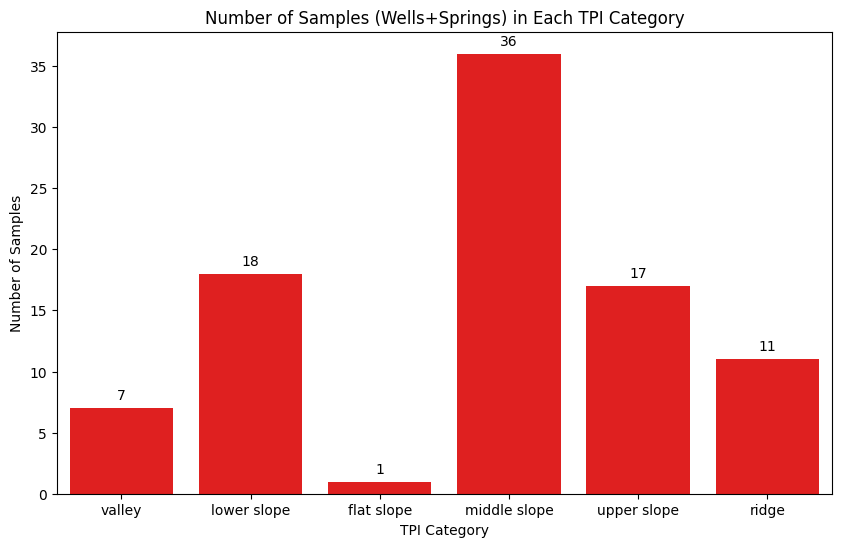

In [119]:
### TPI class dataset

df_tpi = pd.merge(df_full,df_final[['Site ID','TPI300','Source']], on='Site ID')

# Samples at each tpi
tpi_1 = df_tpi[df_tpi['TPI300'] == 1]
tpi_2 = df_tpi[df_tpi['TPI300'] == 2]
tpi_3 = df_tpi[df_tpi['TPI300'] == 3]
tpi_4 = df_tpi[df_tpi['TPI300'] == 4]
tpi_5 = df_tpi[df_tpi['TPI300'] == 5]
tpi_6 = df_tpi[df_tpi['TPI300'] == 6]


### Plot quantiles for each tpi dataframe and give them name as in list: ["valley", "lower slope", "flat slope", "middle slope","upper slope", "ridge"]
tpi_dfs = [tpi_1, tpi_2, tpi_3, tpi_4, tpi_5, tpi_6]
tpi_labels = ["valley", "lower slope", "flat slope", "middle slope", "upper slope", "ridge"]

## **TPI location & Comparison**
### Plot histogram of number of wells/springs located at each topological location
n = [df.shape[0] for df in tpi_dfs]
plt.figure(figsize = (10,6))
ax = sns.barplot(x = tpi_labels, y = n, color = 'red')
plt.title("Number of Samples (Wells+Springs) in Each TPI Category")
plt.xlabel("TPI Category")
plt.ylabel("Number of Samples")

# Add the count (n) on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.show()

In [120]:
### Valley vs. Ridge settings
tpi_valley = pd.concat([tpi_1,tpi_2,tpi_3],ignore_index=True)
tpi_ridge = pd.concat([tpi_4,tpi_5,tpi_6],ignore_index=True)

# Extract columns for non-parametric test
tpi_valley = tpi_valley.loc[:,df_C.columns]
tpi_ridge = tpi_ridge.loc[:,df_C.columns]

# WMW test
sig, valley_ridge_wmw = one_sided_bh_wmw(tpi_valley, tpi_ridge, 'Valley', 'Ridge')


One-Sided Test Results for Significant Features:
   analyte            test  original_pvalue  adjusted_pvalue  significant
40     SO4  Valley < Ridge         0.000697         0.050178         True


Without fdr: 

    analyte            test  original_pvalue  adjusted_pvalue  significant
8        Ba  Valley > Ridge         0.028737         0.425369        False
33  Methane  Valley > Ridge         0.044136         0.425369        False
37       SC  Valley < Ridge         0.037138         0.425369        False
40      SO4  Valley < Ridge         0.000697         0.050178         True
45       Ca  Valley < Ridge         0.014424         0.346166        False
54       Li  Valley < Ridge         0.030468         0.425369        False
56       Ni  Valley < Ridge         0.007618         0.274251        False


Grouped by test: 

  Significant Difference                    WMW
0         Valley > Ridge          [Ba, Methane]
1         Valley < Ridge  [SC, SO4, Ca, Li, Ni]


In [121]:
# BM test
sig, valley_ridge_bm = one_sided_bh_bm(tpi_valley, tpi_ridge,'Valley','Ridge')

One-Sided Test Results for Significant Features:
   analyte            test  original_pvalue  adjusted_pvalue  significant
40     SO4  Valley < Ridge         0.000429         0.030917         True


Without fdr: 

    analyte            test  original_pvalue  adjusted_pvalue  significant
8        Ba  Valley > Ridge         0.031152         0.320420        False
33  Methane  Valley > Ridge         0.044468         0.369664        False
37       SC  Valley < Ridge         0.030897         0.320420        False
40      SO4  Valley < Ridge         0.000429         0.030917         True
43       Al  Valley < Ridge         0.006559         0.141058        False
45       Ca  Valley < Ridge         0.006507         0.141058        False
54       Li  Valley < Ridge         0.030478         0.320420        False
56       Ni  Valley < Ridge         0.007837         0.141058        False


Grouped by test: 

  Significant Difference                         BM
0         Valley > Ridge              

C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8819: RuntimeWarning: invalid value encountered in scalar divide
  wbfn /= (nx + ny) * np.sqrt(nx * Sx + ny * Sy)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:8825: RuntimeWarning: invalid value encountered in scalar divide
  df = df_numer / df_denom
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: p-value cannot be estimated with `distribution='t' because degrees of freedom parameter is undefined (0/0). Try using `distribution='normal'
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\jsu124\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8

In [128]:
tpi_merge = valley_ridge_wmw.merge(valley_ridge_bm,on=['Significant Difference'],how='outer').sort_values('Significant Difference',ascending=False)
tpi_merge.index = ['Valley vs. Ridge']*2
tpi_merge.to_csv(os.path.join(OUTPUT_DIR,'Tables','Table S10 tpi comparison.csv'),index=True)